In [463]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

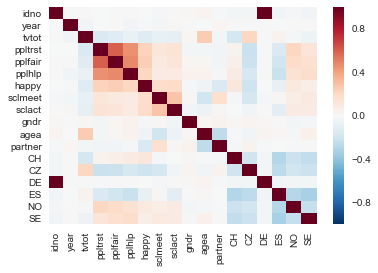

In [464]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Make the categorical variable 'country' into dummies.
df2 = pd.concat([df, pd.get_dummies(df['cntry'])], axis=1)

df2.head(10)

sns.heatmap(df2.corr())

In [465]:
#Very little correlation between the variables
#Let's set up our variables
df2['partner'] = df2['partner'] - 1
y = df2['partner']
X = df2.loc[:, ~df2.columns.isin(['partner', 'cntry', 'idno'])]


print(df2['partner'].value_counts())

0.0    5013
1.0    3134
Name: partner, dtype: int64


In [466]:
#Try to bring them more in balance
yes = df2.loc[np.where(df2['partner'] == 1)]
no = df2.loc[np.where(df2['partner'] == 0)]

# Take a random sample from the no's
msk = np.random.rand(len(no)) < 0.6
no_data = no[msk]

# Join the no data back with the yes's
df3 = no_data.append(yes).dropna()

print(df3['partner'].value_counts())

0.0    3636
1.0    2152
Name: partner, dtype: int64


For some reason, the above method is decreasing both the yes and no categories by 40% even though it is only supposed to drop the no rows by 40%, so let's return to our original data since it's not that imbalance to begin with.

In [467]:
# Create training and test sets through random selection rather than the slicing done in the guided example.
msk = np.random.rand(len(df2)) < 0.8
train_data = df2[msk]
test_data = df2[~msk]


# Define outcome and predictors.
# Set our outcome to 0 and 1.
y_train = train_data['partner']
X_train = train_data.loc[:, ~train_data.columns.isin(['partner', 'cntry', 'idno'])]
y_test = test_data['partner']
X_test = test_data.loc[:, ~test_data.columns.isin(['partner', 'cntry', 'idno'])]

These are the things we can do to try to get a better error rate.
Modifications include:
Creating new features *** Can be done through manually creating features or PCA ***
Applying more overfitting-prevention strategies like subsampling *** Subsample is a parameter ***
More iterations *** Parameter n_estimators ***
Trying a different loss function *** Options are 'exponential' and 'deviance' ***
Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [468]:
#Try by changing the features through PCA.
pca = PCA(n_components=5)
X_std_pca = pca.fit_transform(X_train)
X1 = pd.DataFrame(X_std_pca)

pca = PCA(n_components=5)
X_std_pca = pca.fit_transform(X_test)
X2 = pd.DataFrame(X_std_pca)

In [469]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=0.75, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf.fit(X1, y_train)

predict_train = clf.predict(X1)
predict_test = clf.predict(X2)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.00015337423312883436
Percent Type II errors: 0.0036809815950920245

Test set accuracy:
Percent Type I errors: 0.09956976029502151
Percent Type II errors: 0.21266133988936695


While the training error rate is quite low, the test error, especially type II, is quite high.

In [470]:
#Let's try feature selection through RFE/Logistic regression
lr = LogisticRegression(C=1, penalty='l1')
rfe = RFE(lr,n_features_to_select=8) 
fit = rfe.fit(X,y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))

   Features  Ranking  Support
0      year        1     True
5     happy        1     True
6   sclmeet        1     True
8      gndr        1     True
9      agea        1     True
10       CH        1     True
11       CZ        1     True
15       SE        1     True
4    pplhlp        2    False
2   ppltrst        3    False
1     tvtot        4    False
7    sclact        5    False
3   pplfair        6    False
14       NO        7    False
13       ES        8    False
12       DE        9    False


In [471]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=0.75, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')

rfe_x_train = X_train[['year', 'happy', 'sclmeet', 'gndr', 'agea', 'CH', 'CZ', 'SE']]
rfe_x_test = X_test[['year', 'happy', 'sclmeet', 'gndr', 'agea', 'CH', 'CZ', 'SE']]
clf.fit(rfe_x_train, y_train)

predict_train = clf.predict(rfe_x_train)
predict_test = clf.predict(rfe_x_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.02638036809815951
Percent Type II errors: 0.08466257668711656

Test set accuracy:
Percent Type I errors: 0.10694529809465274
Percent Type II errors: 0.18500307314074985


Unfortunately, this performs all around worse that the PCA model above.

In [472]:
#This one seems to be the best so far.
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=0.75, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.00030674846625766873
Percent Type II errors: 0.004294478527607362

Test set accuracy:
Percent Type I errors: 0.10079901659496004
Percent Type II errors: 0.1800860479409957


Let's use the above and play with the variables and see if we can bring down the Test set error

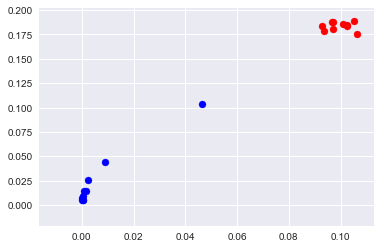

[[0.1, 0.28211432083589427], [0.2, 0.29440688383527969], [0.30000000000000004, 0.28395820528580207], [0.4, 0.28703134603564845], [0.5, 0.27228027043638597], [0.6, 0.27781192378610942], [0.7, 0.28641671788567918], [0.7999999999999999, 0.27658266748617089], [0.8999999999999999, 0.28457283343577133], [0.9999999999999999, 0.28641671788567913]]


In [473]:
variable = 0.1
train_tI = []
train_tII = []
test_tI = []
test_tII = []
list_of_results = []
while variable < 1.00001:
    clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=variable, 
                                              criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                              verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tI.append(train_tI_errors)
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']
    train_tII.append(train_tII_errors)
    
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tI.append(test_tI_errors)
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    test_tII.append(test_tII_errors)
    f = test_tI_errors + test_tII_errors
    list_of_results.append([variable, f])
    variable += 0.1

plt.scatter(train_tI, train_tII, color='b')
plt.scatter(test_tI, test_tII, color='r')

plt.show()
print(list_of_results)

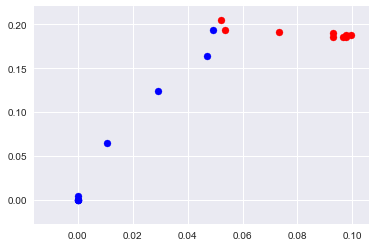

[[1, 0.25691456668715429], [2, 0.24769514443761526], [3, 0.26429010448678547], [4, 0.27904118008604795], [5, 0.2833435771358328], [6, 0.2851874615857406], [7, 0.28272894898586354], [8, 0.28703134603564839], [9, 0.2833435771358328]]


In [474]:
variable = 1
train_tI = []
train_tII = []
test_tI = []
test_tII = []
list_of_results = []
while variable < 10:
    clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=0.75, 
                                              criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_depth=variable, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                              verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tI.append(train_tI_errors)
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']
    train_tII.append(train_tII_errors)
    
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tI.append(test_tI_errors)
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    test_tII.append(test_tII_errors)
    f = test_tI_errors + test_tII_errors
    list_of_results.append([variable, f])
    variable += 1

plt.scatter(train_tI, train_tII, color='b')
plt.scatter(test_tI, test_tII, color='r')

plt.show()
print(list_of_results)

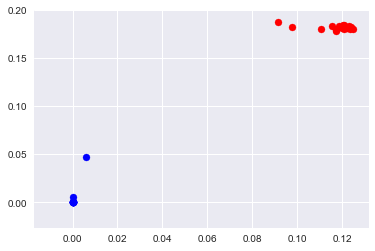

[[500, 0.27965580823601721], [1000, 0.28027043638598648], [1500, 0.29071911493546404], [2000, 0.3011677934849416], [2500, 0.29932390903503381], [3000, 0.30178242163491087], [3500, 0.29563614013521822], [4000, 0.30424093423478793], [4500, 0.29686539643515675], [5000, 0.30178242163491087], [5500, 0.30669944683466505], [6000, 0.30362630608481866], [6500, 0.29748002458512601], [7000, 0.30669944683466505], [7500, 0.30424093423478793], [8000, 0.30424093423478793], [8500, 0.30485556238475719], [9000, 0.30239704978488013], [9500, 0.30608481868469573], [10000, 0.30547019053472646]]


In [475]:
variable = 500
train_tI = []
train_tII = []
test_tI = []
test_tII = []
list_of_results = []
while variable < 10001:
    clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=variable, subsample=0.75, 
                                              criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                              verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tI.append(train_tI_errors)
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']
    train_tII.append(train_tII_errors)
    
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tI.append(test_tI_errors)
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    test_tII.append(test_tII_errors)
    f = test_tI_errors + test_tII_errors
    list_of_results.append([variable, f])
    variable += 500

plt.scatter(train_tI, train_tII, color='b')
plt.scatter(test_tI, test_tII, color='r')

plt.show()
print(list_of_results)

In [476]:
#Optimal seems to be:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=0.75, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=8, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.09711124769514444
Percent Type II errors: 0.1856177012907191


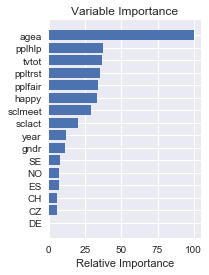

In [477]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()